<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

### <center> Автор материала: Безрученко Павел

## <center> Индивидуальный проект по анализу данных </center>

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ признаков
 - Первичный визуальный анализ признаков
 - Закономерности, "инсайты", особенности данных
 - Предобработка данных
 - Кросс-валидация, подбор параметров
 - Построение кривых валидации и обучения 
 - Прогноз для тестовой или отложенной выборки
 - Оценка модели с описанием выбранной метрики
 - Выводы
 
 Более детальное описание [тут](https://goo.gl/cJbw7V).

Ссылка на данные: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/data

Описание признаков: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv('data/data.csv', sep=',')

###  Часть 1. Описание набора данных и признаков

Признаки были получены из оцифрованных изображений (FNA) молочной железы. Они описывают
характеристики ячеек клеток, присутствующих в изображении.

Наша задача бинарно классифицировать пациентов по типу опухоли - доброкачественная или злокачественная.
Целевой признак "diagnosis", значения которого ("M" и "B") соответсвуют диагнозу ("Malignant" или "Benign").

Количество сэмплов: 569

Количество фич: 32 (ID, диагноз и 30 переменных в формате real, обозначающих характеристики опухоли)

В данных пропусков нет. 



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

Для каждой опухоли вычисляются десять вещественных признаков:

+ **радиус**
+ **текстура** (стандартное отклонение значений шкалы серого)
+ **периметр**
+ **площадь**
+ **гладкость**
+ **компактность** (периметр ^ 2 / площадь - 1,0)
+ **вогнутость**
+ **вогнутые точки** (количество вогнутых участков контура)
+ **симметрия**
+ **фрактальная размерность**
    
Mean, SE (standard error) и Worst этих признаков были рассчитаны для каждого изображения,
в результате чего мы имеем 30 фич. 

Например, поле 3 представляет собой средний радиус, поле
13 - Радиус SE, поле 23 является Worst Радиусом.

###  Часть 2. Первичный анализ признаков

In [4]:
df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  compactness_mean  concavity_mean  concave points_mean  symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  area_se  smoothness_se  compactness_se  concavity_se  concave points_se  symmetry_se  fractal_dimension_se  radius_worst  texture_worst  perimeter_worst  area_worst  smoothness_worst  compactness_worst  concavity_worst  concave points_worst  symmetry_worst  fractal_dimension_worst  Unnamed: 32
0    842302         M        17.99         10.38          122.80     1001.0          0.11840           0.27760          0.3001              0.14710         0.2419                 0.07871     1.0950      0.9053         8.589   153.40       0.006399         0.04904       0.05373            0.01587      0.03003              0.006193         25.38          17.33           184.60      2019.0            0.1622             0.6656           0.7119                0.2654          0.4601                  0.11890          NaN
1    842517         M        20.57         17.77          132.90     1326.0          0.08474           0.07864          0.0869              0.07017         0.1812                 0.05667     0.5435      0.7339         3.398    74.08       0.005225         0.01308       0.01860            0.01340      0.01389              0.003532         24.99          23.41           158.80      1956.0            0.1238             0.1866           0.2416                0.1860          0.2750                  0.08902          NaN
2  84300903         M        19.69         21.25          130.00     1203.0          0.10960           0.15990          0.1974              0.12790         0.2069                 0.05999     0.7456      0.7869         4.585    94.03       0.006150         0.04006       0.03832            0.02058      0.02250              0.004571         23.57          25.53           152.50      1709.0            0.1444             0.4245           0.4504                0.2430          0.3613                  0.08758          NaN
3  84348301         M        11.42         20.38           77.58      386.1          0.14250           0.28390          0.2414              0.10520         0.2597                 0.09744     0.4956      1.1560         3.445    27.23       0.009110         0.07458       0.05661            0.01867      0.05963              0.009208         14.91          26.50            98.87       567.7            0.2098             0.8663           0.6869                0.2575          0.6638                  0.17300          NaN
4  84358402         M        20.29         14.34          135.10     1297.0          0.10030           0.13280          0.1980              0.10430         0.1809                 0.05883     0.7572      0.7813         5.438    94.44       0.011490         0.02461       0.05688            0.01885      0.01756              0.005115         22.54          16.67           152.20      1575.0            0.1374             0.2050           0.4000                0.1625          0.2364                  0.07678          NaN

Посмотрим на распределение целевого признака

In [5]:
print('Malignant:', len(df[df['diagnosis'] == 'M']))
print('Benign:', len(df[df['diagnosis'] == 'B']))

Malignant: 212
Benign: 357


Проверим датасет на наличие пропущенных значений

In [6]:
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

Отлично, все значения присутствуют, кроме полностью нулевого признака, который мы позже удалим

Основная статистическая информация:

In [7]:
df.describe()

id  radius_mean  texture_mean  perimeter_mean    area_mean  smoothness_mean  compactness_mean  concavity_mean  concave points_mean  symmetry_mean  fractal_dimension_mean   radius_se  texture_se  perimeter_se     area_se  smoothness_se  compactness_se  concavity_se  concave points_se  symmetry_se  fractal_dimension_se  radius_worst  texture_worst  perimeter_worst   area_worst  smoothness_worst  compactness_worst  concavity_worst  concave points_worst  symmetry_worst  fractal_dimension_worst  Unnamed: 32
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000       569.000000        569.000000      569.000000           569.000000     569.000000              569.000000  569.000000  569.000000    569.000000  569.000000     569.000000      569.000000    569.000000         569.000000   569.000000            569.000000    569.000000     569.000000       569.000000   569.000000        569.000000         569.000000       569.000000            569.000000      569.000000               569.000000          0.0
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104         0.096360          0.104341        0.088799             0.048919       0.181162                0.062798    0.405172    1.216853      2.866059   40.337079       0.007041        0.025478      0.031894           0.011796     0.020542              0.003795     16.269190      25.677223       107.261213   880.583128          0.132369           0.254265         0.272188              0.114606        0.290076                 0.083946          NaN
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129         0.014064          0.052813        0.079720             0.038803       0.027414                0.007060    0.277313    0.551648      2.021855   45.491006       0.003003        0.017908      0.030186           0.006170     0.008266              0.002646      4.833242       6.146258        33.602542   569.356993          0.022832           0.157336         0.208624              0.065732        0.061867                 0.018061          NaN
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000         0.052630          0.019380        0.000000             0.000000       0.106000                0.049960    0.111500    0.360200      0.757000    6.802000       0.001713        0.002252      0.000000           0.000000     0.007882              0.000895      7.930000      12.020000        50.410000   185.200000          0.071170           0.027290         0.000000              0.000000        0.156500                 0.055040          NaN
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000         0.086370          0.064920        0.029560             0.020310       0.161900                0.057700    0.232400    0.833900      1.606000   17.850000       0.005169        0.013080      0.015090           0.007638     0.015160              0.002248     13.010000      21.080000        84.110000   515.300000          0.116600           0.147200         0.114500              0.064930        0.250400                 0.071460          NaN
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000         0.095870          0.092630        0.061540             0.033500       0.179200                0.061540    0.324200    1.108000      2.287000   24.530000       0.006380        0.020450      0.025890           0.010930     0.018730              0.003187     14.970000      25.410000        97.660000   686.500000          0.131300           0.211900         0.226700              0.099930        0.282200                 0.080040          NaN
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000         0.105300          0.130400        0.130700             0.074000       0.195700                0.066120    0.478900    1.474000      3.357000   45.190000       0.008146        0.032450      0.042050           0.014710     0.023480              0.004558     18

In [8]:
df.get_ftype_counts()

float64:dense    31
int64:dense       1
object:dense      1
dtype: int64

В датасете только один категориальный признак, который является целевым, все остальные числа с плавающей точкой

###  Часть 3. Предобработка данных 

Представим переменную diagnosis в бинарном виде

In [9]:
df.diagnosis = df.diagnosis.replace({'M': 1, 'B': 0})
df.head()

id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  compactness_mean  concavity_mean  concave points_mean  symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  area_se  smoothness_se  compactness_se  concavity_se  concave points_se  symmetry_se  fractal_dimension_se  radius_worst  texture_worst  perimeter_worst  area_worst  smoothness_worst  compactness_worst  concavity_worst  concave points_worst  symmetry_worst  fractal_dimension_worst  Unnamed: 32
0    842302          1        17.99         10.38          122.80     1001.0          0.11840           0.27760          0.3001              0.14710         0.2419                 0.07871     1.0950      0.9053         8.589   153.40       0.006399         0.04904       0.05373            0.01587      0.03003              0.006193         25.38          17.33           184.60      2019.0            0.1622             0.6656           0.7119                0.2654          0.4601                  0.11890          NaN
1    842517          1        20.57         17.77          132.90     1326.0          0.08474           0.07864          0.0869              0.07017         0.1812                 0.05667     0.5435      0.7339         3.398    74.08       0.005225         0.01308       0.01860            0.01340      0.01389              0.003532         24.99          23.41           158.80      1956.0            0.1238             0.1866           0.2416                0.1860          0.2750                  0.08902          NaN
2  84300903          1        19.69         21.25          130.00     1203.0          0.10960           0.15990          0.1974              0.12790         0.2069                 0.05999     0.7456      0.7869         4.585    94.03       0.006150         0.04006       0.03832            0.02058      0.02250              0.004571         23.57          25.53           152.50      1709.0            0.1444             0.4245           0.4504                0.2430          0.3613                  0.08758          NaN
3  84348301          1        11.42         20.38           77.58      386.1          0.14250           0.28390          0.2414              0.10520         0.2597                 0.09744     0.4956      1.1560         3.445    27.23       0.009110         0.07458       0.05661            0.01867      0.05963              0.009208         14.91          26.50            98.87       567.7            0.2098             0.8663           0.6869                0.2575          0.6638                  0.17300          NaN
4  84358402          1        20.29         14.34          135.10     1297.0          0.10030           0.13280          0.1980              0.10430         0.1809                 0.05883     0.7572      0.7813         5.438    94.44       0.011490         0.02461       0.05688            0.01885      0.01756              0.005115         22.54          16.67           152.20      1575.0            0.1374             0.2050           0.4000                0.1625          0.2364                  0.07678          NaN

Удалим столбец с пустыми значениями и идетификаторы пациентов

In [10]:
df.drop(columns=['Unnamed: 32', 'id'], inplace=True)

###  Часть 4. Первичный визуальный анализ признаков

Более наглядное распределение целевой переменной:

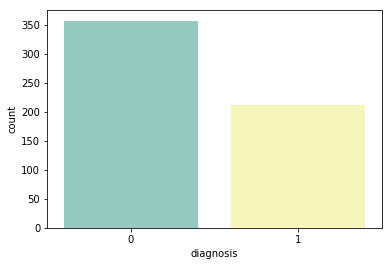

In [11]:
sns.countplot(x=df['diagnosis'], palette="Set3")
plt.show()

Проверим наши данные на наличие выбросов и посмотрим на разницу значений между переменными:

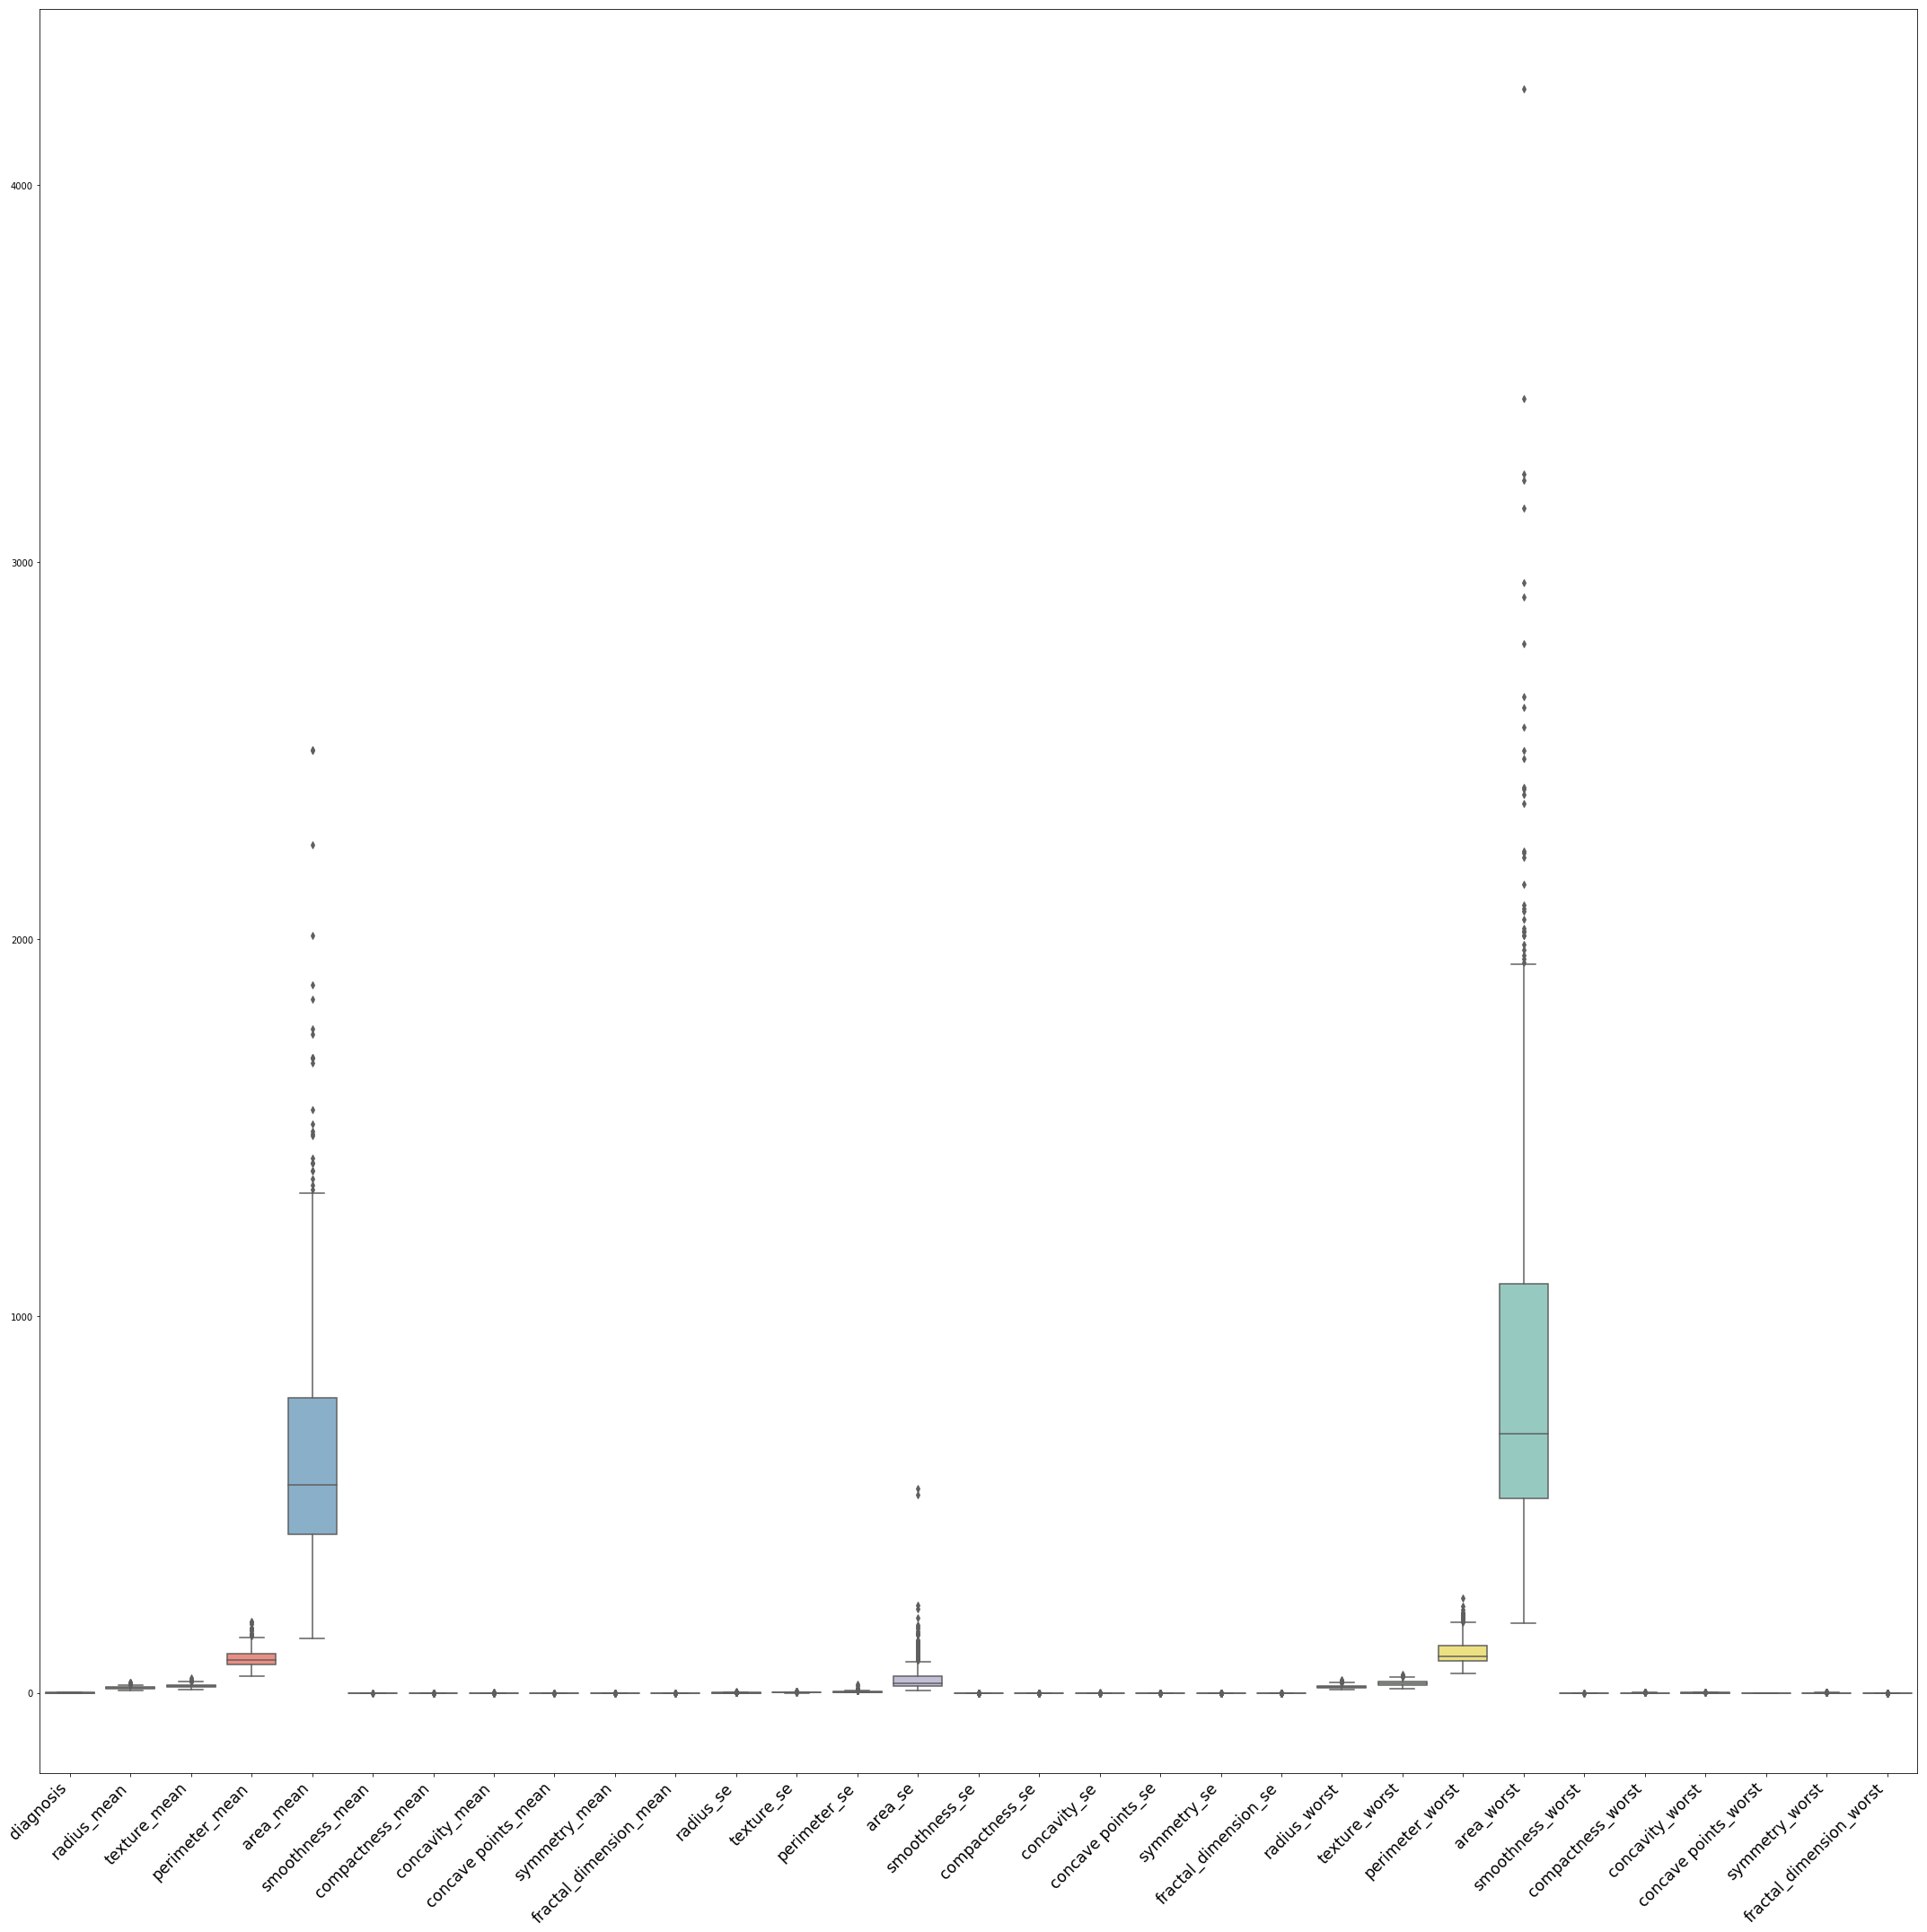

In [12]:
plt.figure(figsize=[30, 30])
ax = sns.boxplot(data=df, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xticklabels(ax.get_xticklabels(), size='xx-large')
plt.tight_layout()
plt.show()

Посмотрим на средний радиус в контексте целевой переменной

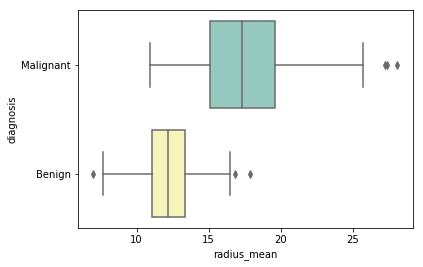

In [13]:
sns.boxplot(x='radius_mean', y=df['diagnosis'].replace({1: 'Malignant', 0: 'Benign'}), data=df, palette="Set3")
plt.show()

Видим, что в основном средний радиус опухоли значительно больше у людей со злокачественной опухолью.

Нужно проверить, есть ли отличия по другим признакам.

Построим pairplot для mean фич:

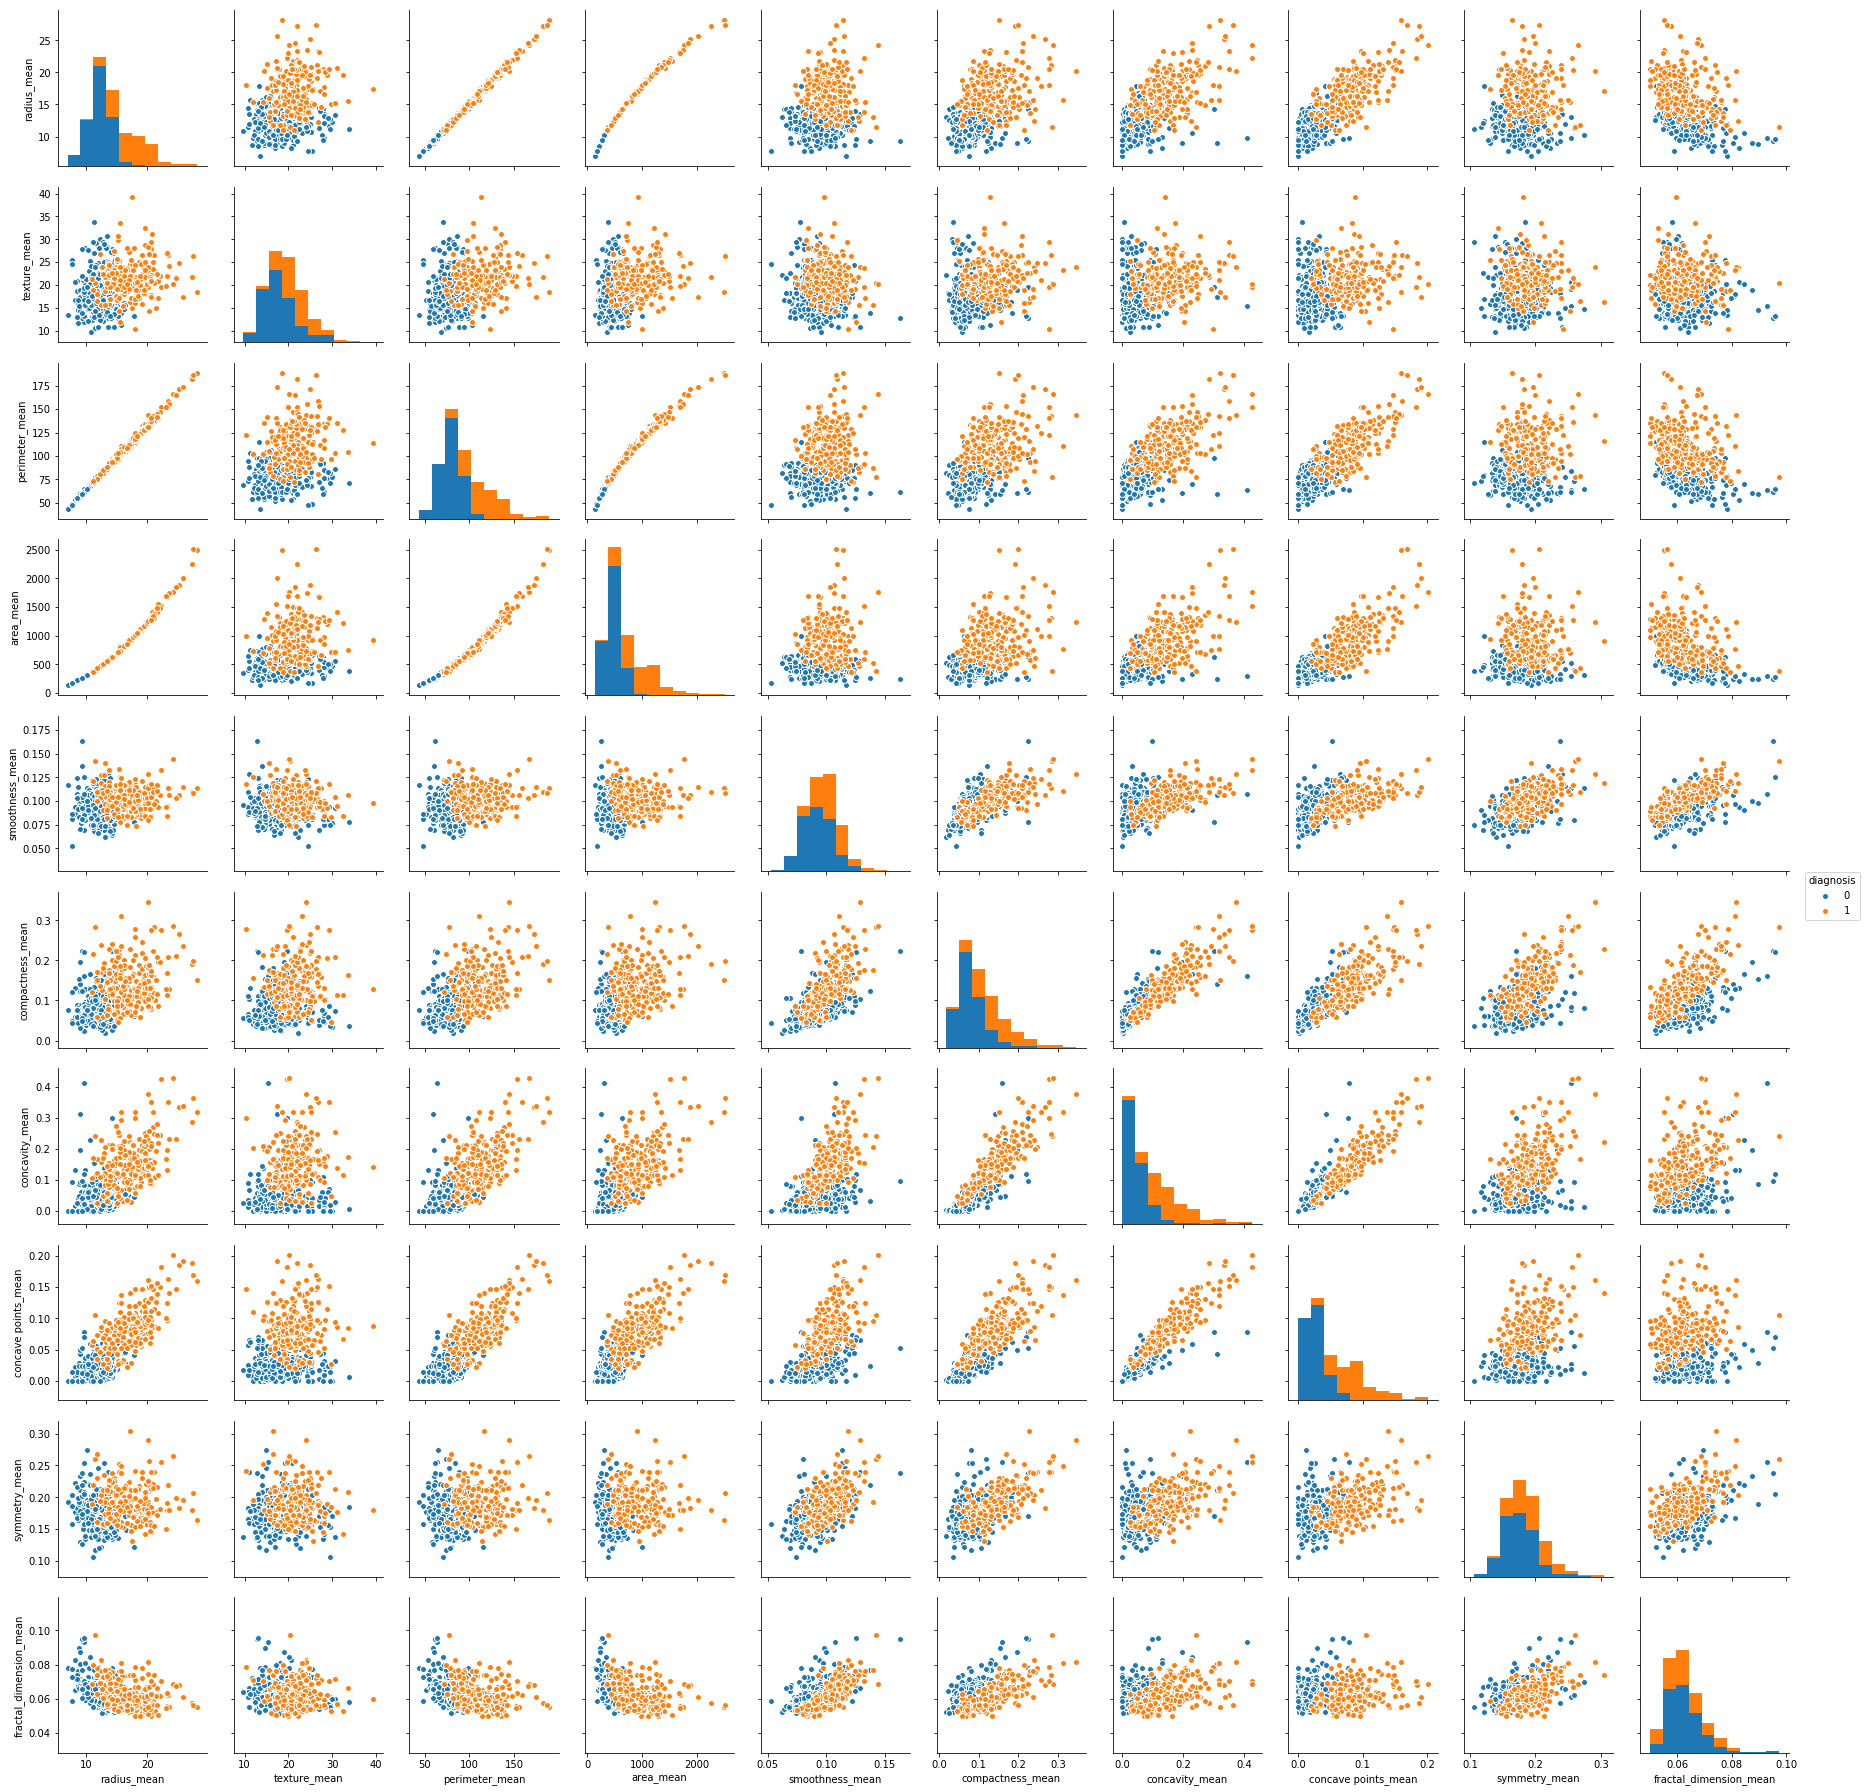

<Figure size 2160x2160 with 0 Axes>

In [14]:
ax = sns.pairplot(data=df, hue='diagnosis', 
             vars=['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',\
                   'smoothness_mean', 'compactness_mean', 'concavity_mean', \
                   'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean'])
plt.figure(figsize=[30,30])
plt.show();

Для standart error:

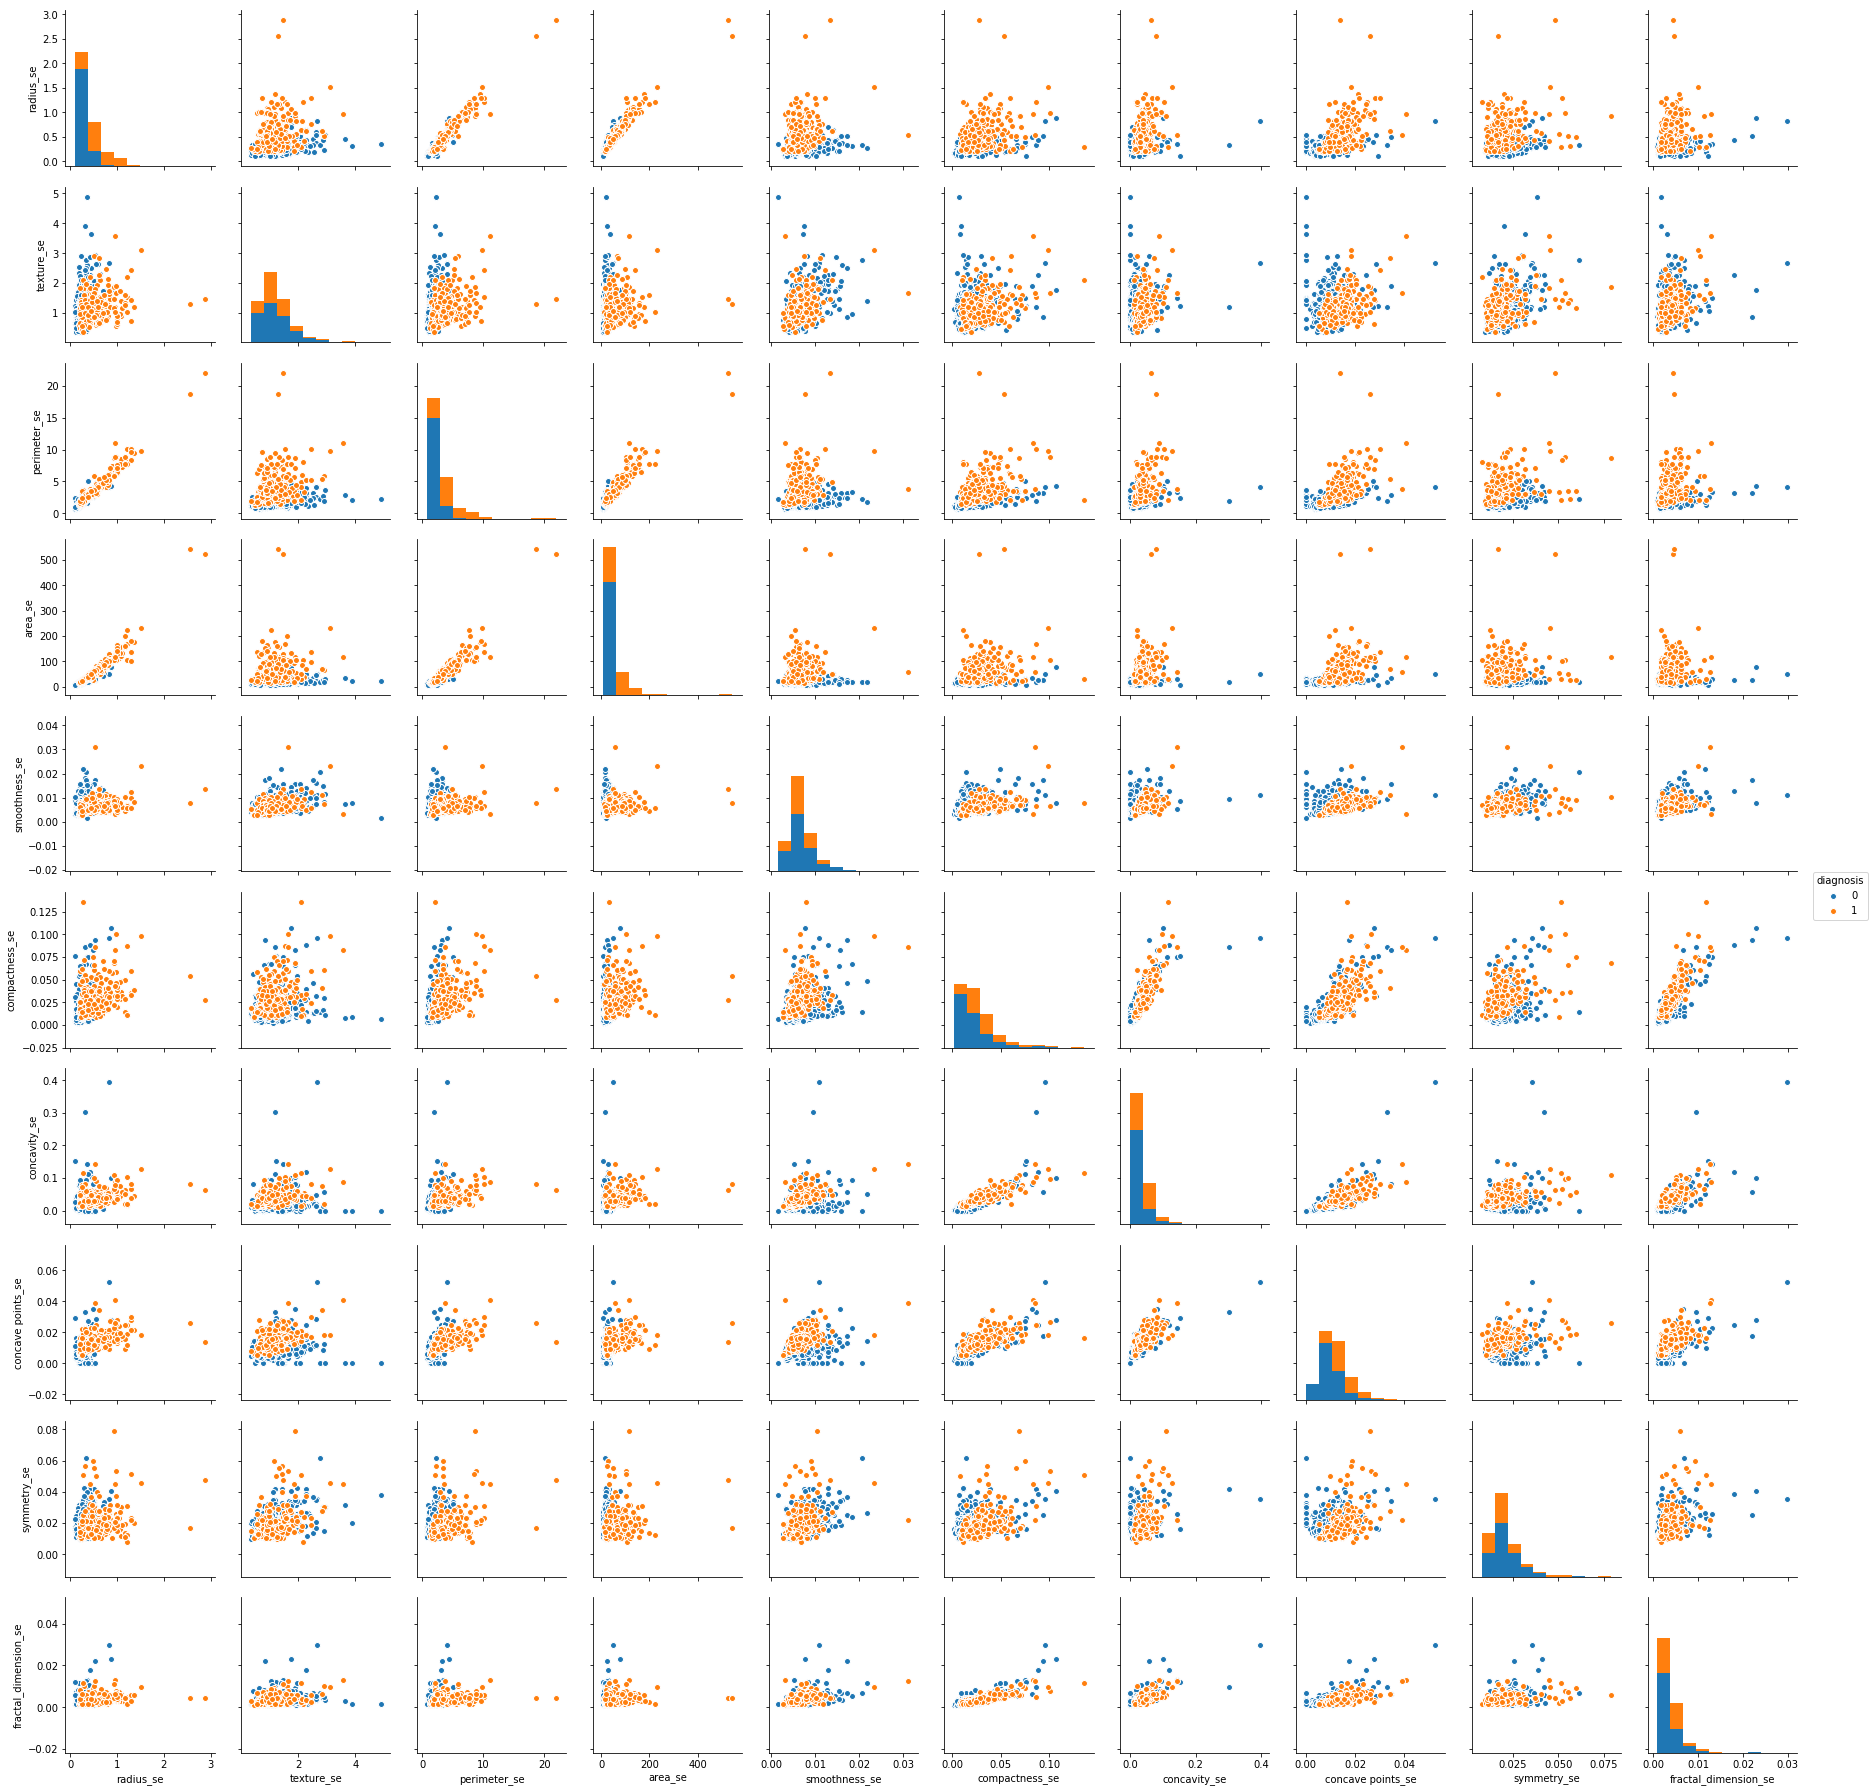

<Figure size 2160x2160 with 0 Axes>

In [15]:
ax = sns.pairplot(data=df, hue='diagnosis', 
             vars=['radius_se', 'texture_se', 'perimeter_se', 'area_se',\
                   'smoothness_se', 'compactness_se', 'concavity_se', \
                   'concave points_se', 'symmetry_se', 'fractal_dimension_se'])
plt.figure(figsize=[30,30])
plt.show();

Для worst признаков:

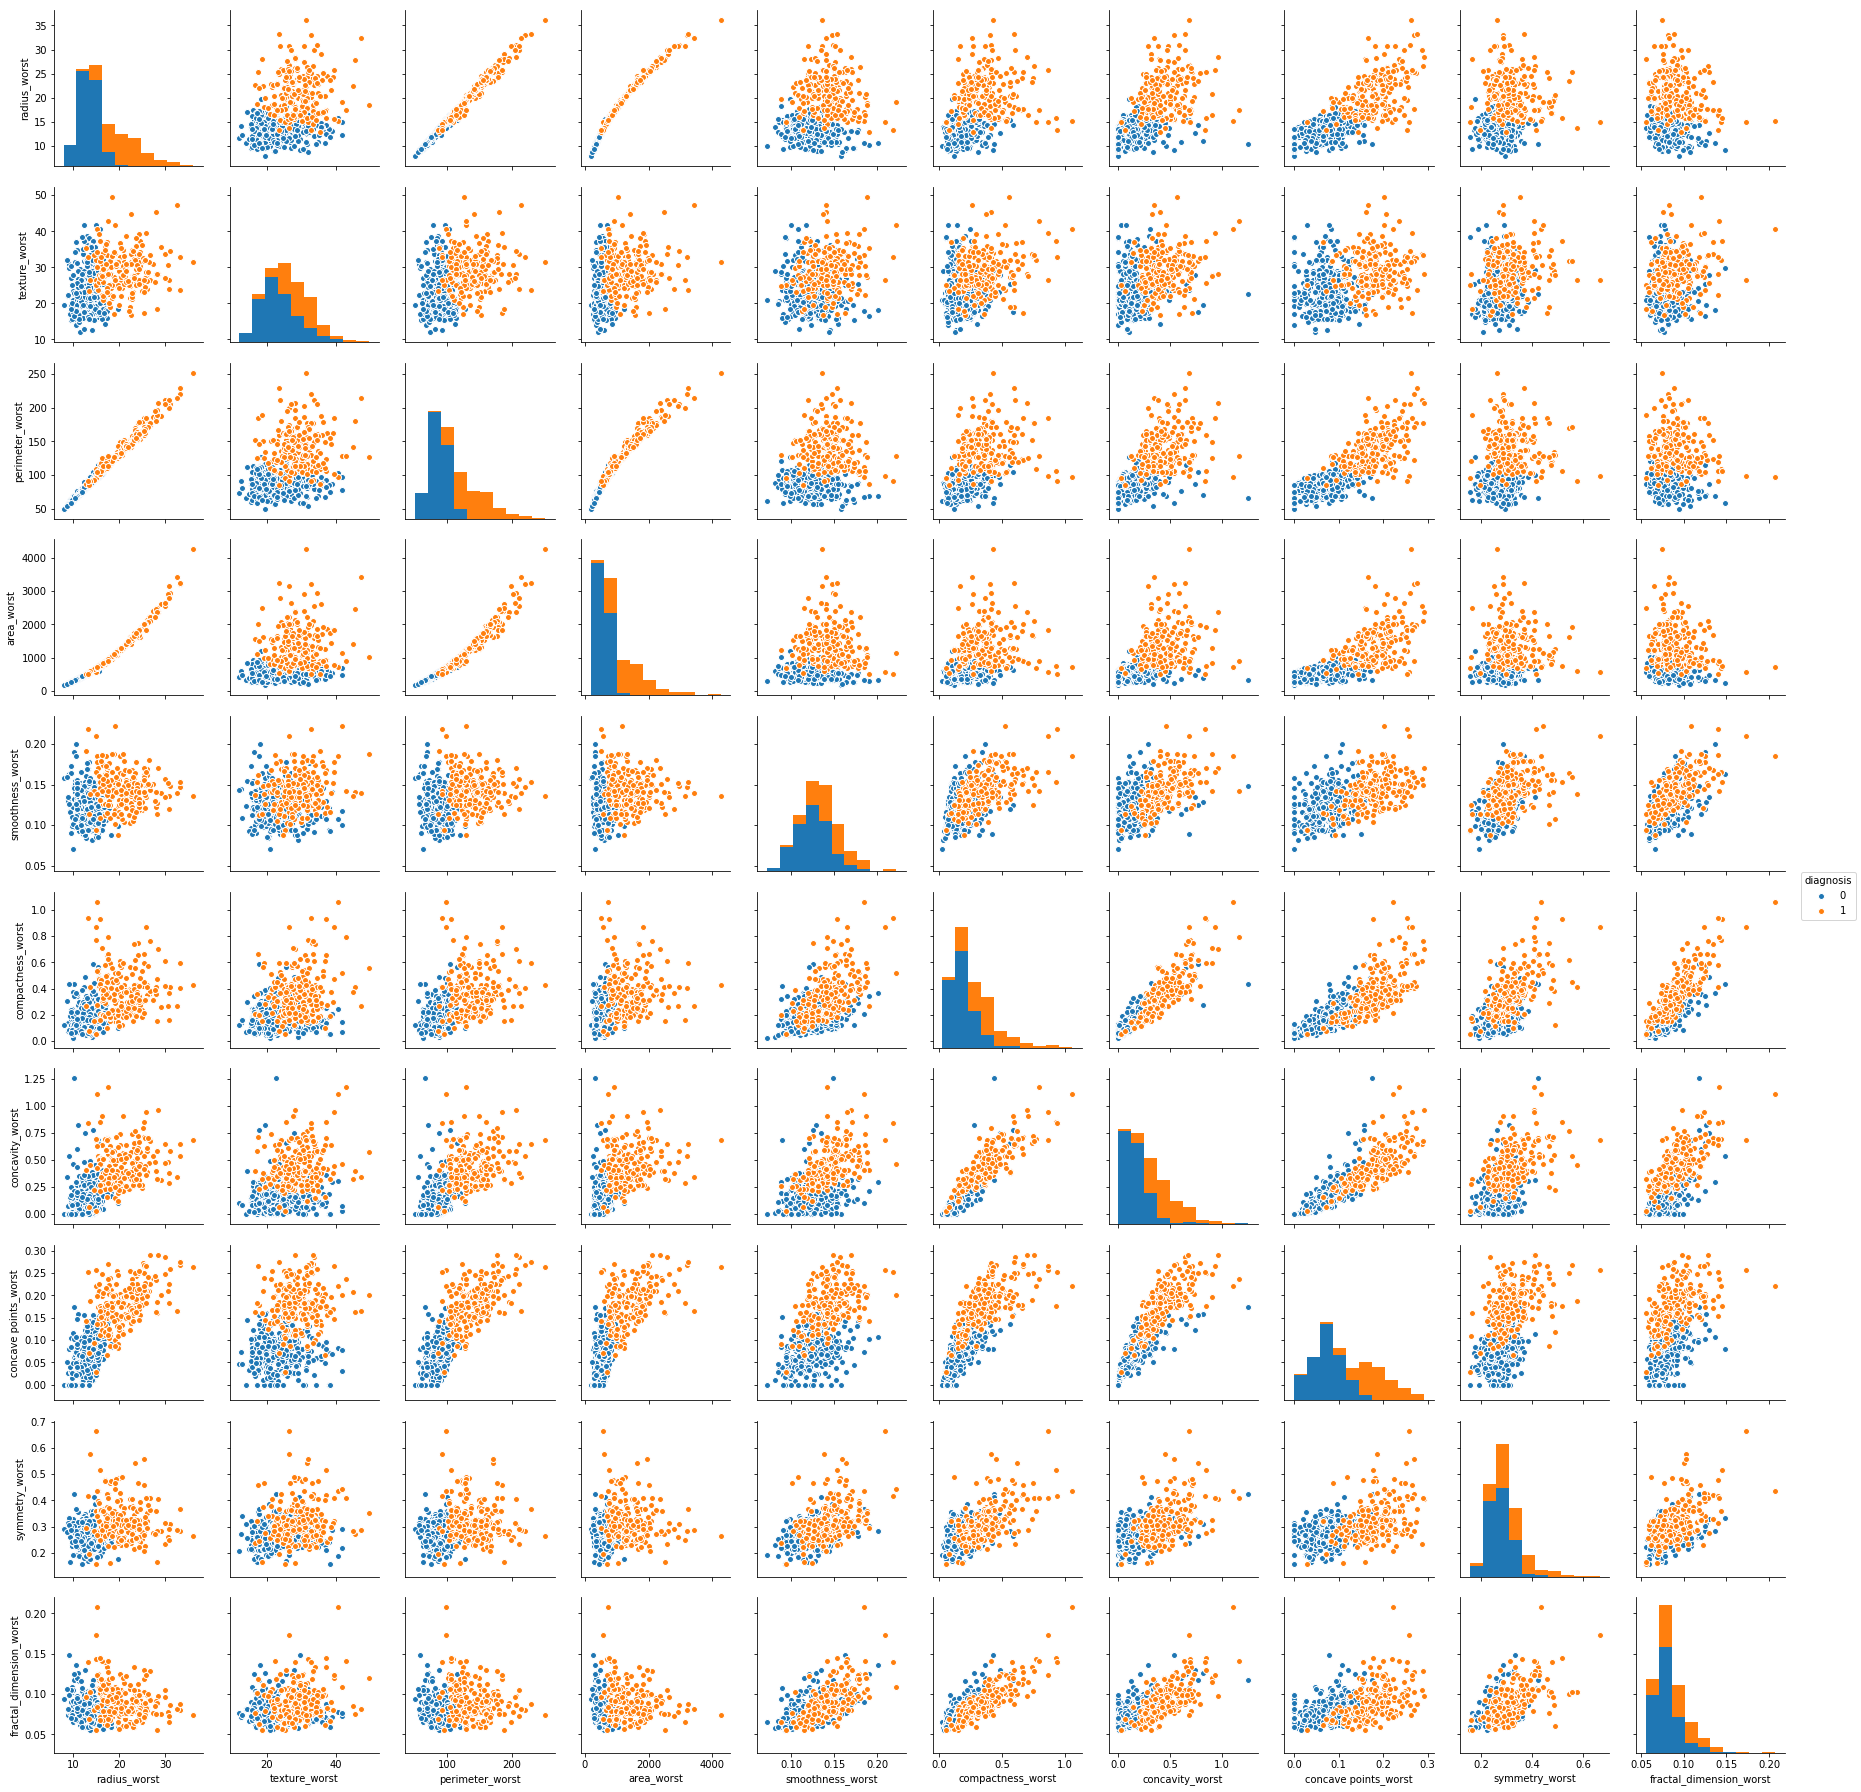

<Figure size 2160x2160 with 0 Axes>

In [16]:
ax = sns.pairplot(data=df, hue='diagnosis', 
             vars=['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',\
                   'smoothness_worst', 'compactness_worst', 'concavity_worst', \
                   'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'])
plt.figure(figsize=[30,30])
plt.show();

Попробуем теперь уменьшить размерность наших данных и разбить их на кластеры

In [17]:
scaler = StandardScaler()

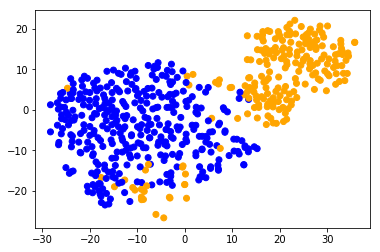

CPU times: user 27.5 s, sys: 2.41 s, total: 29.9 s
Wall time: 32.4 s


In [18]:
%%time
df_scaled = scaler.fit_transform(df.drop(columns=['diagnosis']))
tsne = TSNE(random_state=22)
tsne_representation_full = tsne.fit_transform(df_scaled)

plt.scatter(tsne_representation_full[:, 0], tsne_representation_full[:, 1], 
            c=df['diagnosis'].map({0: 'blue', 1: 'orange'}));
plt.show()

Посмотрим на матрицу корреляций:

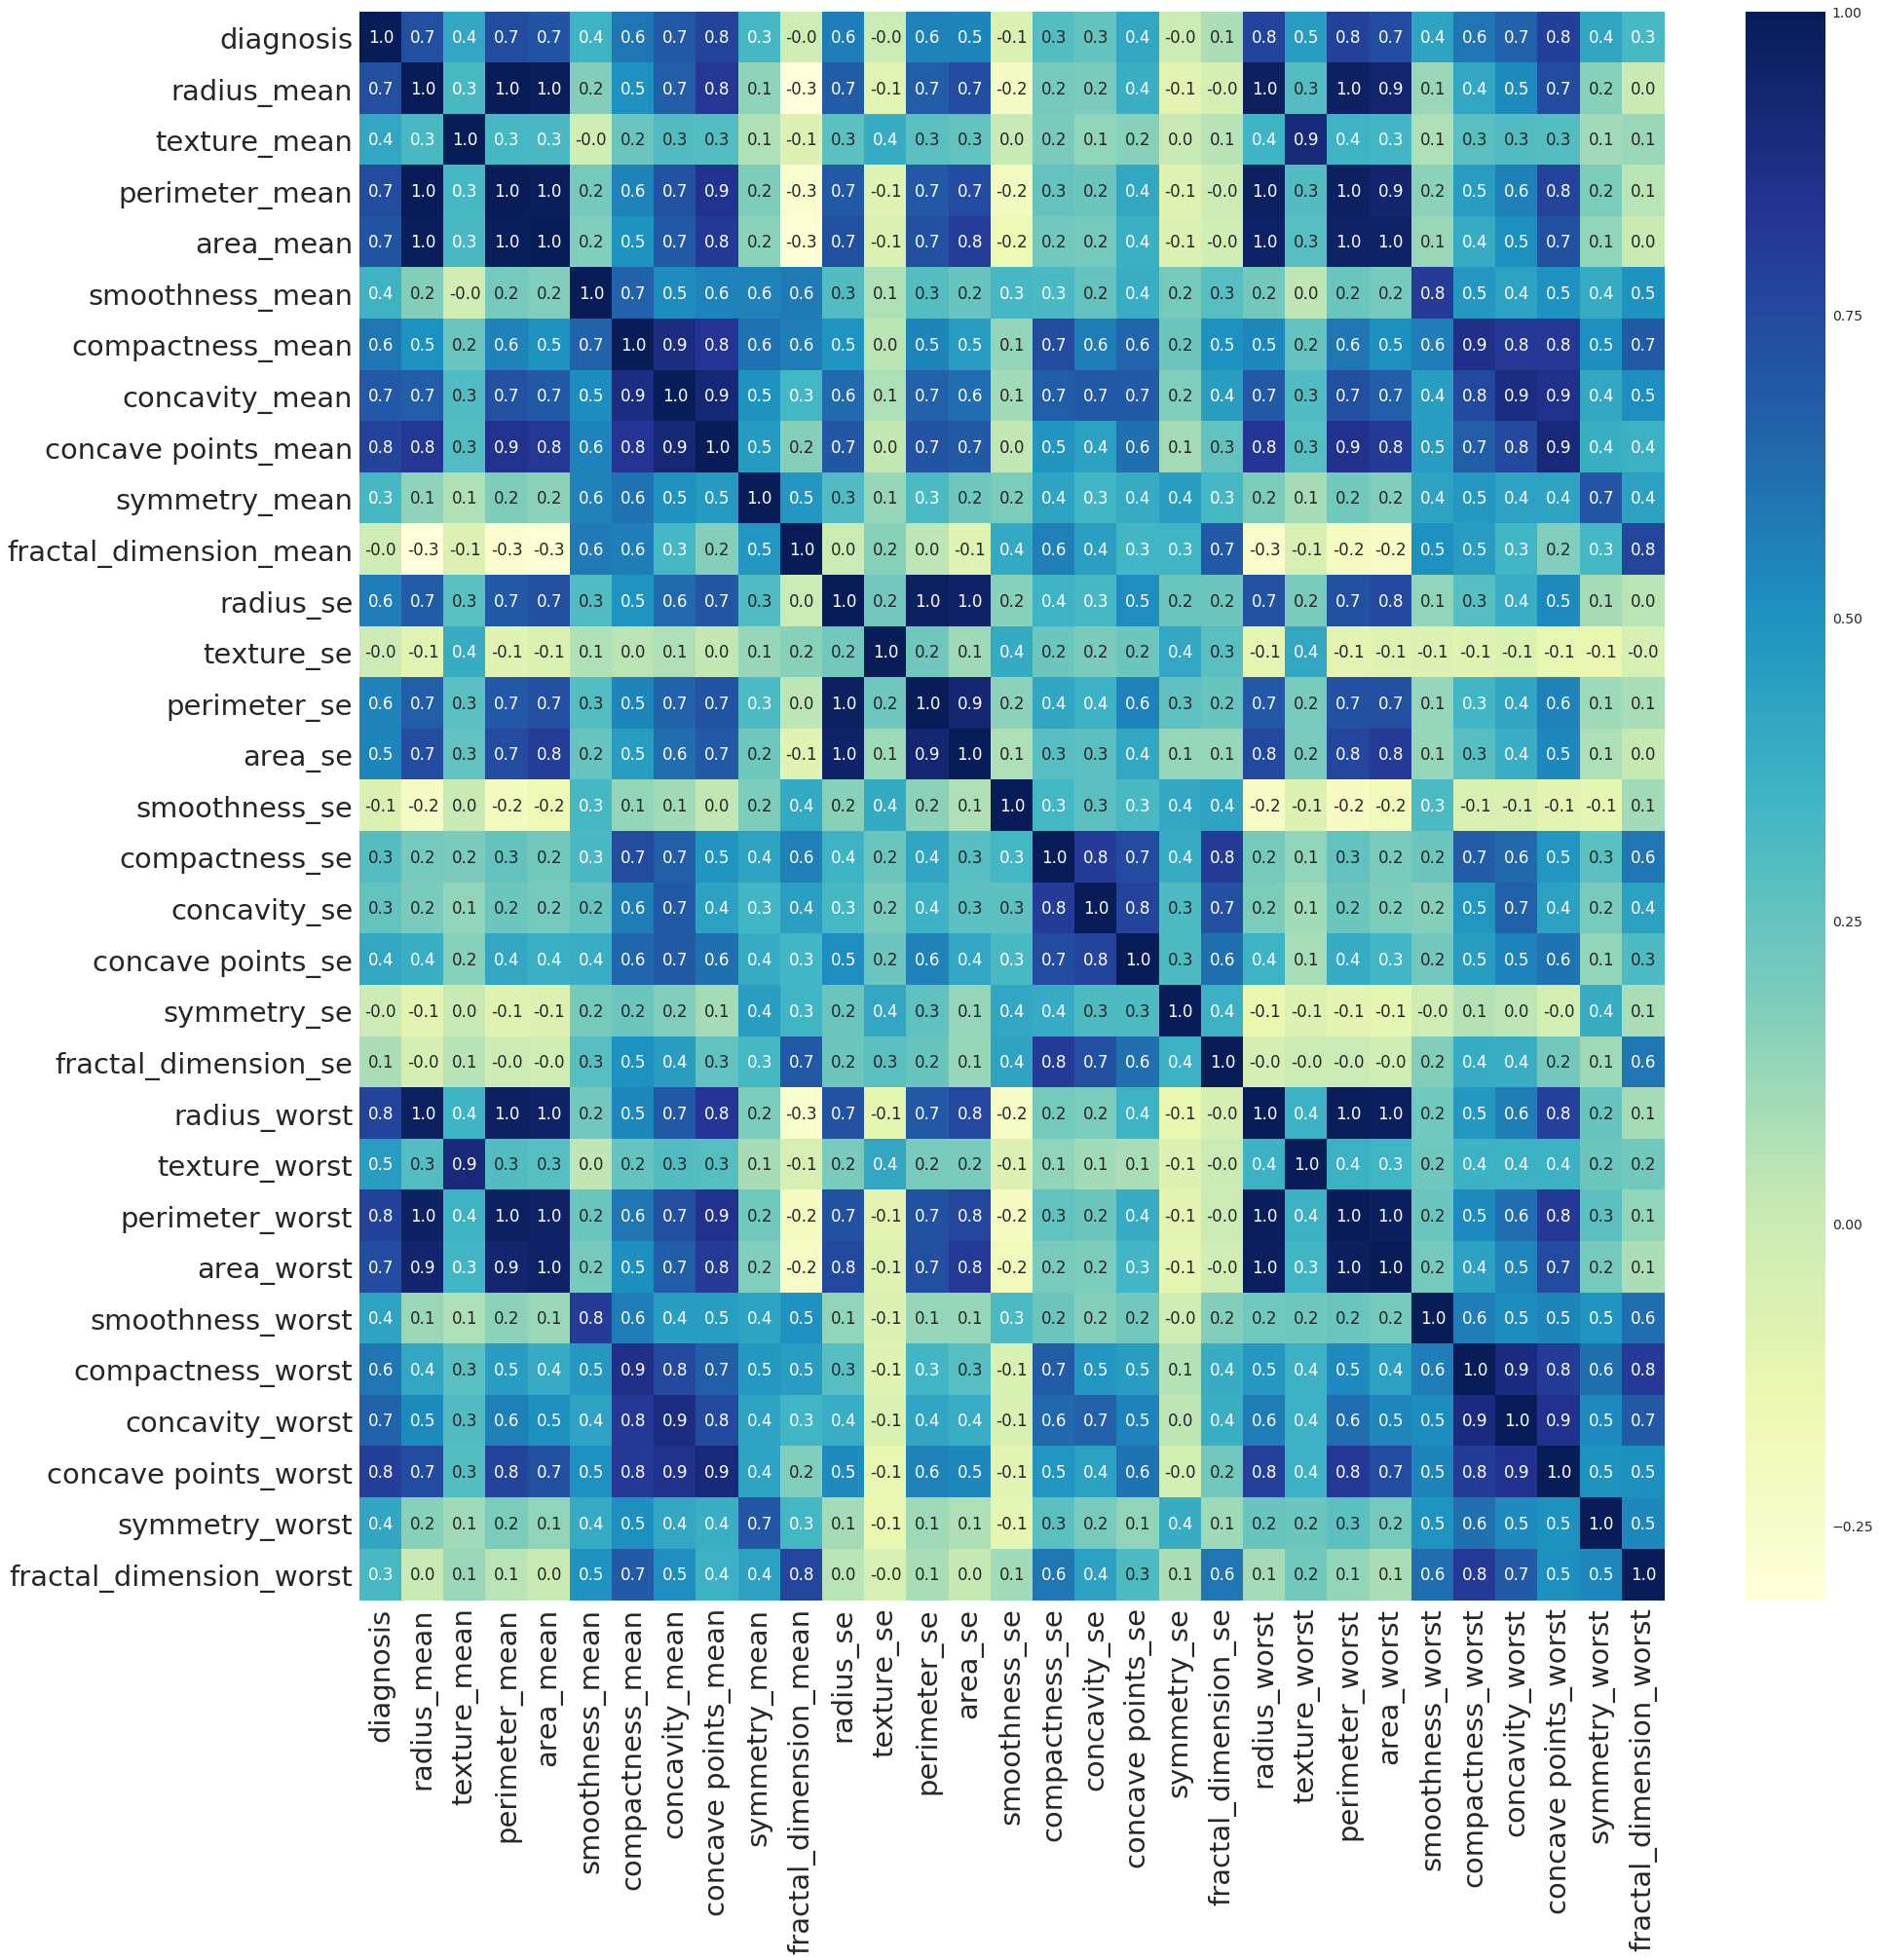

In [62]:
plt.figure(figsize=[30, 30])
ax = sns.heatmap(df.corr(), fmt = ".1f", cmap='YlGnBu', cbar = True, annot=True)
ax.set_xticklabels(ax.get_xticklabels(), size='xx-large')
ax.set_yticklabels(ax.get_yticklabels(), size='xx-large')
sns.set(font_scale=1.4)
plt.show();

###  Часть 5. Закономерности, "инсайты", особенности данных

Судя по boxplot'ам в данных присутствуют выбросы, пара признаков значительно отличаются от большинства по масштабу.

У _mean и _worst признаков на большинстве графиков видно четкое разбиение по целевому признаку.
Снижение размерности данных с помощью TSN-e также показало два четких кластера с несущественным количеством аномалий (которые могут быть выбросами или ошибками в данных). 

Подобный результат должен означать высокую точность предсказаний у модели.

На матрице корреляций оказалось много значений, стремящихся к единице, в основном потому, что некоторые признаки вычисялются друг из друга или имеют прямую зависимость между собой (например: radius_mean и radius_worst)

###  Часть 6. Кросс-валидация, подбор параметров

В качестве модели для классификации опухолей будем использовать случайный лес, т.к. данная модель нечувствительна к выбросам и может выдавать высокую точность без масштабирования и детальной настройки

In [20]:
y = df.diagnosis
X = df.drop(columns=['diagnosis'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

In [24]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=21)
rfc_params = {'max_depth': range(2, 10),
             'n_estimators': [2, 20, 100],
             'criterion': ['entropy', 'gini'],
             'max_features': ['sqrt', None], 
             'min_samples_split' : range(2, 6),
             'max_leaf_nodes' : [100, None]}

Найдем наилучшее сочетание гипер-параметров в модели

In [25]:
%%time
rfc_search = GridSearchCV(rfc, param_grid=rfc_params, n_jobs=-1)
rfc_search.fit(X_train, y_train)

CPU times: user 10.6 s, sys: 801 ms, total: 11.4 s
Wall time: 13min 42s


In [26]:
rfc_search.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': 100,
 'min_samples_split': 2,
 'n_estimators': 20}

###  Часть 7. Построение кривых валидации и обучения 

In [27]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    '''
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    '''
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [37]:
rfc_best = RandomForestClassifier(max_depth=4, max_features='sqrt', max_leaf_nodes=100, \
                                  n_estimators=20, min_samples_split=2, random_state=21)

In [38]:
rfc_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='sqrt', max_leaf_nodes=100,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=21, verbose=0, warm_start=False)

<Figure size 576x432 with 0 Axes>

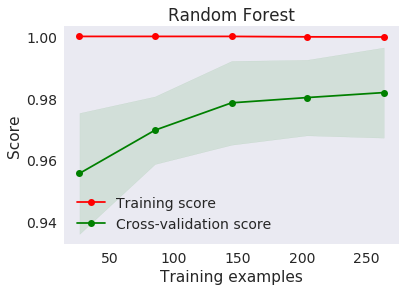

In [39]:
plt.figure(figsize=(8, 6))
plot_learning_curve(rfc_best, 'Random Forest', X_train, y_train, cv=3, n_jobs=-1);
plt.show()

Посмотрим на важность признаков при обучении

In [40]:
print('Feature ranking:')
for f in range(X_train.shape[1]):
    print('%d. feature %s (%f)' % (f + 1, X_train.columns[f],
                                      rfc_best.feature_importances_[f]))

Feature ranking:
1. feature radius_mean (0.042028)
2. feature texture_mean (0.008672)
3. feature perimeter_mean (0.072861)
4. feature area_mean (0.002542)
5. feature smoothness_mean (0.002440)
6. feature compactness_mean (0.017395)
7. feature concavity_mean (0.004433)
8. feature concave points_mean (0.172036)
9. feature symmetry_mean (0.002966)
10. feature fractal_dimension_mean (0.001082)
11. feature radius_se (0.003201)
12. feature texture_se (0.002579)
13. feature perimeter_se (0.020062)
14. feature area_se (0.015143)
15. feature smoothness_se (0.000787)
16. feature compactness_se (0.006148)
17. feature concavity_se (0.004297)
18. feature concave points_se (0.004839)
19. feature symmetry_se (0.002878)
20. feature fractal_dimension_se (0.004475)
21. feature radius_worst (0.214633)
22. feature texture_worst (0.006503)
23. feature perimeter_worst (0.173957)
24. feature area_worst (0.091570)
25. feature smoothness_worst (0.015827)
26. feature compactness_worst (0.005735)
27. feature con

Самыми важными признаками оказались radius_worst и perimeter_worst, забавно

###  Часть 8. Прогноз для тестовой или отложенной выборки

Ради интереса попробуем обучить модель и сделать прогноз для двух выборок - для полной и для выборки только из двух признаков (radius_worst и perimeter_worst)

In [54]:
rfc_main_features = RandomForestClassifier(max_depth=4, max_features='sqrt', max_leaf_nodes=100, \
                                  n_estimators=20, min_samples_split=2, random_state=21)
rfc_main_features.fit(X_train[['radius_worst', 'perimeter_worst']], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='sqrt', max_leaf_nodes=100,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=21, verbose=0, warm_start=False)

In [55]:
predictions_all = rfc_best.predict(X_test)

In [56]:
predictions_main_features = rfc_main_features.predict(X_test[['radius_worst', 'perimeter_worst']])

###  Часть 9. Оценка модели с описанием выбранной метрики

Распределение данных по целевому признаку неравномерно (37%), поэтому в качестве метрики будем использовать precision

In [57]:
round(precision_score(y_test, predictions_all), 3)

0.968

Для выборки со всеми признаками мы получили достаточно высокую точность (около 96%-99% в зависимости от данных)

In [58]:
round(precision_score(y_test, predictions_main_features), 3)

0.93

Обучение на всего лишь двух признаках (radius_worst и perimeter_worst) выдает метрику precision около 91%-93%

Похоже, что для высокого качества классификации опухолей достаточно иметь представление хотя бы об их размере

### Часть 10. Выводы 

RandomForestClassifier обученный на тестовой выборке выдает 96%-99% по метрике precision.

Наибольшее значение для классификации имеют только 2-3 признака, причиной этому может быть либо природа данных, либо их искусственность.
Возможно, выборка слишком узкая, а в реальной жизни доброкачественная и злокачественная опухоли могут иметь одинаковый размер, но отличаться по другим признакам.

Также не ясно, как наша модель поведет себя на большом количестве данных, т.к. у нас в выборке меньше 600 сэмплов. Скорее всего модель потребуется переобучить, вследсвие чего метрика может снизиться.

Однако, по графику с валидационной кривой видно, что по мере увеличения выборки растет и точность.

Вывод: для использования в реальных условиях необходимо обеспечить модель необходимым количеством информации, после чего можно будет понять целесообразно ее использовать или нет.